# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign
from mpi4py import MPI
from params import nz
from petsc4py import PETSc
from solvers import initialize,solve_pde, time_stepping
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_steady
from post_process import interp
from scipy.interpolate import interp1d
# import sympy as sp

Define domain:

In [24]:
# generate mesh
N_f = 2  # effective stress at base of fringe 
z_l = 3
z_b = 1e-3
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])

# define initial condition N that satisfies the
# elliptic problem: D(phi,S) N']' = F(phi,S)   
# which is valid for rigid solutions (dN/dt + v_i dN/dz = 0)
initial = initialize(domain,N_f,eps_min=1e-10)

# interpolate solution, save in numpy arrays, and plot
z,N = interp(initial,domain)

In [25]:
# set freezing speed and timesteps 
v_i = 0.035
timesteps = np.linspace(0,1e3,1000)

# solve the time-dependent problem
N,z,new_lens,heave,converged = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

In [26]:
# set freezing speed and timesteps 
v_i2 = 0.025
timesteps2 = np.linspace(0,1e3,2000)

# solve the time-dependent problem
N2,z2,new_lens2,heave2,converged2 = time_stepping(domain,initial,N_f,v_i2,timesteps2,eps=1e-10)

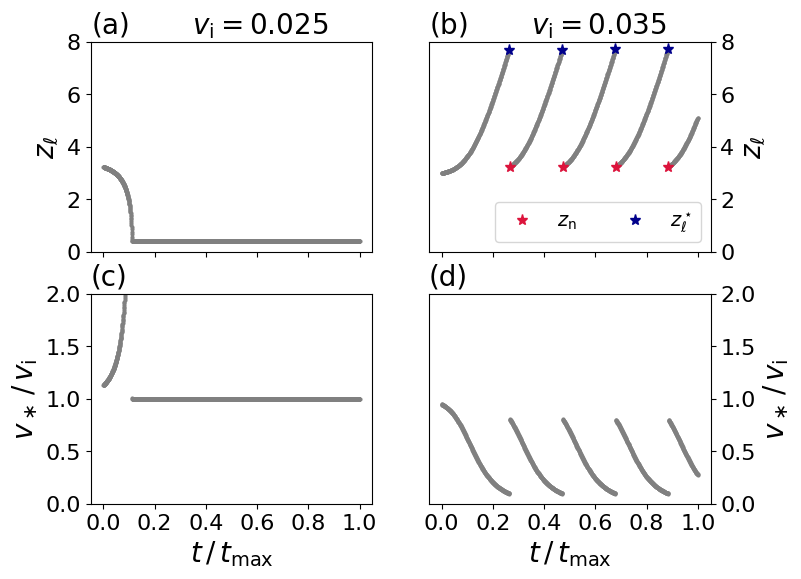

In [43]:
# plot position of active ice lens over time

z_l = np.max(z,axis=1)
old_lens = np.roll(new_lens,-1)

z_l2 = np.max(z2,axis=1)


plt.figure(figsize=(8,6))

plt.subplot(221)
plt.title(r'(a) $\qquad v_\mathrm{i}=0.025$',fontsize=20,loc='left')
plt.plot(timesteps2/timesteps.max(),z_l2,'o',markersize=2,color='gray')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=20)
plt.ylim(0,8)

plt.gca().xaxis.set_ticklabels([])

plt.subplot(223)
plt.title(r'(c)',fontsize=20,loc='left')

heave_mean2 = np.mean(heave2,axis=1)/v_i2

plt.plot(timesteps2[heave_mean2!=0]/timesteps.max(),heave_mean2[heave_mean2!=0],'o',markersize=2,color='gray')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'${v}_\ast\,/\,v_\mathrm{i}$',fontsize=20)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.ylim(0,2)



plt.subplot(222)
plt.title(r'(b) $\qquad v_\mathrm{i}=0.035$',fontsize=20,loc='left')
plt.plot(timesteps/timesteps.max(),z_l,'o',markersize=2,color='gray')
plt.plot(timesteps[new_lens==1]/timesteps.max(),z_l[new_lens==1],'*',markersize=8,color='crimson',label=r'$z_\mathrm{n}$')
plt.plot(timesteps[old_lens==1]/timesteps.max(),z_l[old_lens==1],'*',markersize=8,color='darkblue',label=r'$z_\ell^\star$')

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=20)
plt.ylim(0,8)
lgnd = plt.legend(fontsize=14,loc='lower right',ncol=2)
lgnd.legendHandles[0].set_markersize(8)
lgnd.legendHandles[1].set_markersize(8)
plt.gca().xaxis.set_ticklabels([])

plt.subplot(224)
plt.title(r'(d)',fontsize=20,loc='left')
heave_mean = np.mean(heave,axis=1)/v_i

plt.plot(timesteps[heave_mean!=0]/timesteps.max(),heave_mean[heave_mean!=0],'o',markersize=2,color='gray')

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'${v}_\ast\,/\,v_\mathrm{i}$',fontsize=20)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.ylim(0,2)
plt.savefig('constant_phi',bbox_inches='tight')
plt.show()
plt.close()